# Preface

In this notebook, we explore the use of autoencoders for image compression and denoising.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from PIL import Image
sns.set(font_scale=1.5, style='dark')

# The Pokemon Dataset

So far our applications in this class have been rather serious. Here, to demonstrate the use of autoencoders we will use a fun dataset. The pokemon dataset!

See [here](https://www.kaggle.com/vishalsubbiah/pokemon-images-and-types) for more information.

In [2]:
import kaggle
kaggle.api.authenticate()

kaggle.api.dataset_download_files(
    'vishalsubbiah/pokemon-images-and-types',
    path='./pokemon',
    quiet=False,
    unzip=True,
    force=False,
)

100%|██████████| 2.47M/2.47M [00:01<00:00, 1.88MB/s]


The images are in multiple formats including png and jpg formats. So we will do some pre-processing and change all of them into (120, 120, 3) arrays, representing a RGB image.

In [3]:
names = []
images = []

fill_color = (255, 255, 255)

for img in os.listdir('./pokemon/images/images'):
    im = Image.open('./pokemon/images/images/{}'.format(img))
    names.append(img.split('.')[0])
    if img.split('.')[1] == 'png':
        im = im.convert("RGBA")
        if im.mode in ('RGBA', 'LA'):
            bg = Image.new(im.mode[:-1], im.size, fill_color)
            bg.paste(im, im.split()[-1])
            im = bg
    images.append(np.asarray(im))
images = np.asarray(images) / 255.0

We will write a function to plot the images.

In [4]:
def plot_images(images, n_plots=5):
    fig, ax = plt.subplots(1, n_plots, figsize=(5*n_plots, 4))

    for i, a in zip(images, ax):
        a.imshow(i)
        a.axis('off')

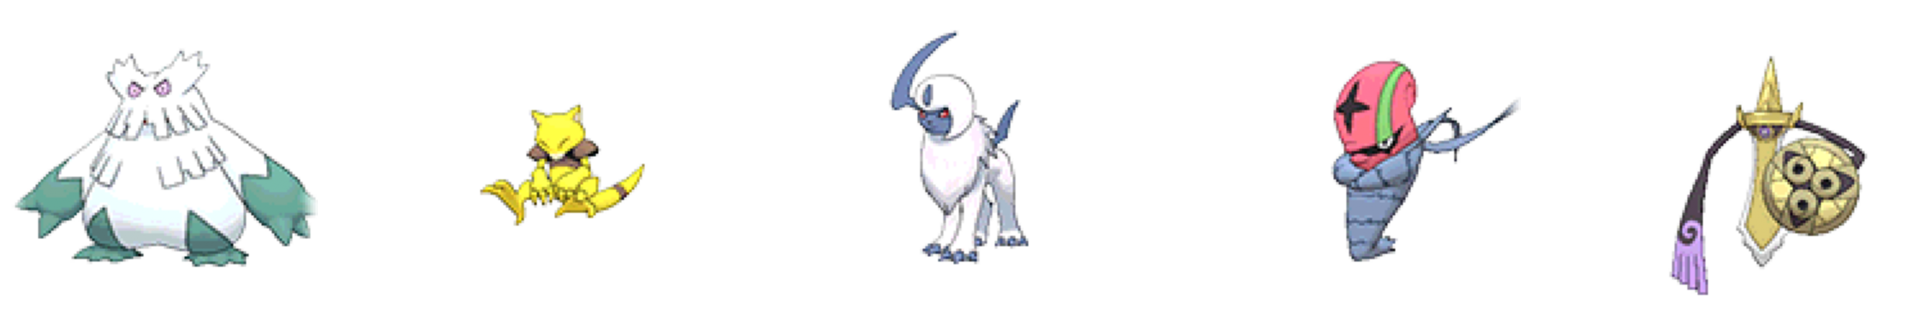

In [5]:
plot_images(images=images)

We keep a testing set to evaluate our autoencoders' ability to generalize.

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
x_train, x_test = train_test_split(images, test_size=0.1, random_state=123)

In [8]:
x_train.shape

(728, 120, 120, 3)

# Fully Connected Autoencoder

We start with the simplest autoencoder consisting of fully connected layers alone.

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tqdm.keras import TqdmCallback

In [10]:
# Encoder

encoder = Sequential()
encoder.add(Flatten(input_shape=(120, 120, 3)))
encoder.add(Dense(units=128, activation='relu'))
encoder.add(Dense(units=32, activation='relu'))

# Decoder

decoder = Sequential()
decoder.add(Dense(units=128, activation='relu', input_shape=(32, )))
decoder.add(Dense(units=120*120*3, activation='sigmoid'))
decoder.add(Reshape(target_shape=(120, 120, 3)))

autoencoder = Sequential([encoder, decoder])

In [11]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32)                5533856   
                                                                 
 sequential_1 (Sequential)   (None, 120, 120, 3)       5577024   
                                                                 
Total params: 11,110,880
Trainable params: 11,110,880
Non-trainable params: 0
_________________________________________________________________


As we can see, there are over 11 million parameters! This is a huge network. Let us compile and train it.

In [12]:
def train_and_save(model, path, **kwargs):
    if path.exists():
        model.load_weights(str(path))
    else:
        model.compile(loss='binary_crossentropy', optimizer='adam')
        _ = model.fit(**kwargs)
        model.save_weights(str(path))

In [13]:
train_and_save(
    model=autoencoder,
    path=Path('./pokemon_ae_fcnn.h5'),
    x=x_train,
    y=x_train,
    batch_size=64,
    validation_data=(x_test, x_test),
    verbose=0,
    epochs=200,
    callbacks=[TqdmCallback(verbose=1)],
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Let us check the reconstruction results on the test set.

In [14]:
x_test_pred = autoencoder.predict(x_test)

3/3 [==============================] - 0s 8ms/step


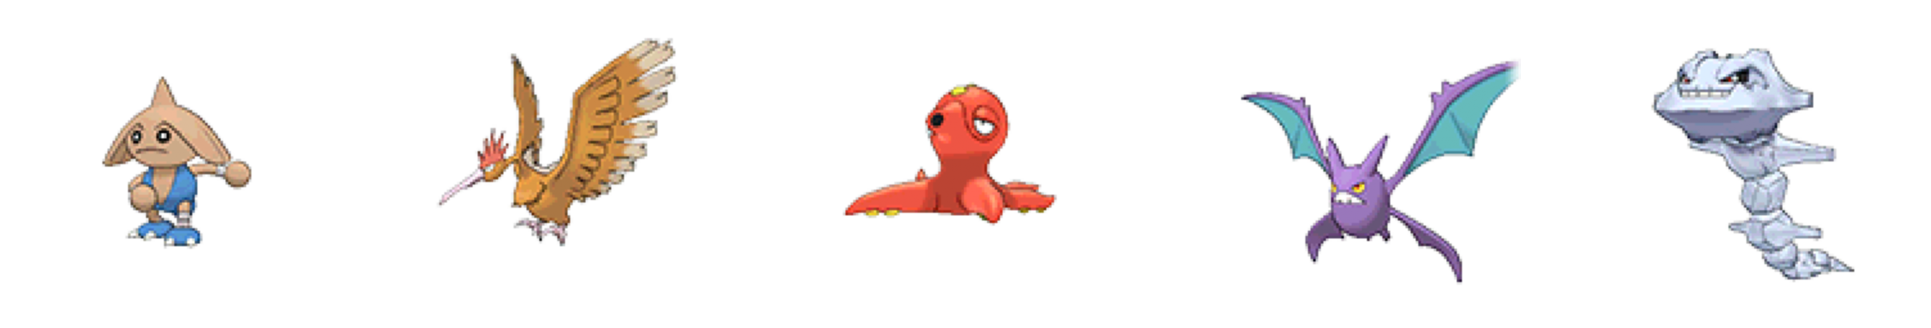

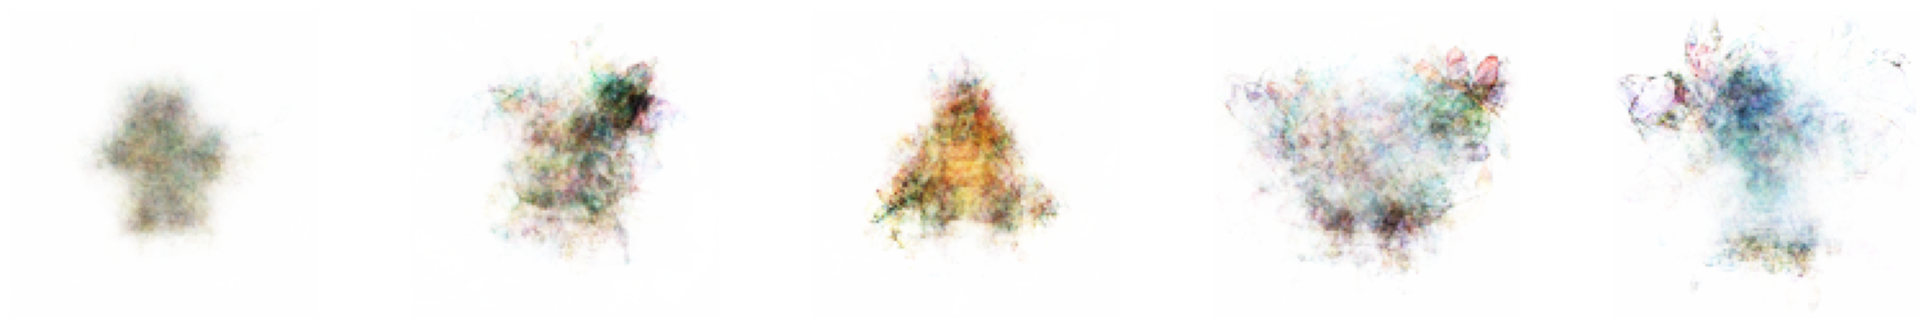

In [15]:
plot_images(x_test)
plot_images(x_test_pred)

Observe that although the reconstructed images are not random, they are far from satisfactory. 

In fact, we can check the performance on the training set to confirm that this is not a problem of overfitting.

In [16]:
x_train_pred = autoencoder.predict(x_train)

23/23 [==============================] - 0s 10ms/step


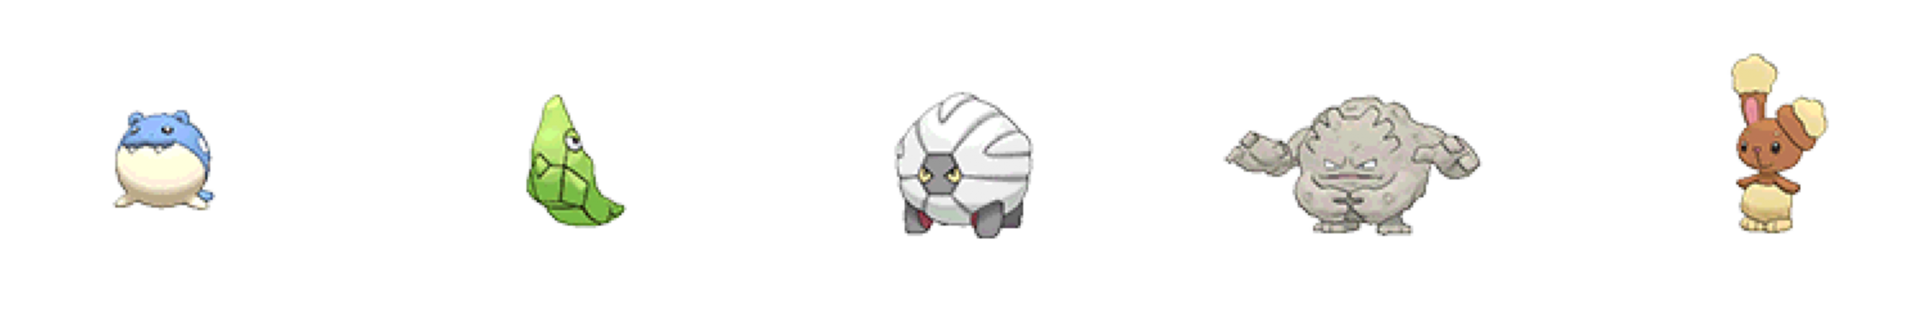

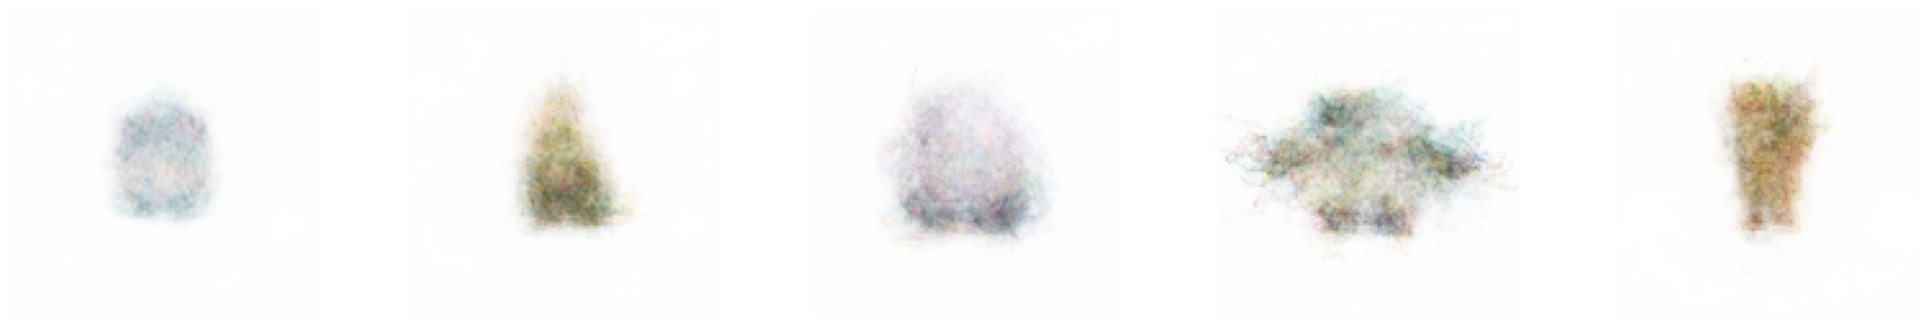

In [17]:
plot_images(x_train)
plot_images(x_train_pred)

# Convolutional Autoencoder

Since we are dealing with images, it is likely that the fully connected network can capture the features much better.

In [18]:
from tensorflow.keras.layers import AveragePooling2D, Conv2D, UpSampling2D

For the decoder, we will decrease dimensions using the pooling operation, preserving the structure of the image.

In [19]:
# Encoder

encoder = Sequential()
encoder.add(
    Conv2D(
        filters=16,
        kernel_size=5,
        padding='same',
        activation='relu',
        input_shape=(120, 120, 3)))
encoder.add(AveragePooling2D())
encoder.add(
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
encoder.add(AveragePooling2D())
encoder.add(
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
encoder.add(AveragePooling2D())
encoder.add(
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))

In [20]:
# Decoder

decoder = Sequential()
decoder.add(
    Conv2D(
        filters=64,
        kernel_size=3,
        padding='same',
        activation='relu',
        input_shape=(15, 15, 16)))
decoder.add(UpSampling2D())
decoder.add(
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
decoder.add(UpSampling2D())
decoder.add(
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
decoder.add(UpSampling2D())
decoder.add(
    Conv2D(filters=3, kernel_size=5, padding='same', activation='sigmoid'))

In [21]:
autoencoder = Sequential([encoder, decoder])

Check that we have much fewer parameters this time!

In [22]:
autoencoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 15, 15, 16)        33584     
                                                                 
 sequential_4 (Sequential)   (None, 120, 120, 3)       33571     
                                                                 
Total params: 67,155
Trainable params: 67,155
Non-trainable params: 0
_________________________________________________________________


In [23]:
train_and_save(
    model=autoencoder,
    path=Path('./pokemon_ae_cnn.h5'),
    x=x_train,
    y=x_train,
    batch_size=64,
    validation_data=(x_test, x_test),
    verbose=0,
    epochs=80,
    callbacks=[TqdmCallback(verbose=1)],
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Let us now look at the results of the predictions

In [24]:
x_test_pred = autoencoder.predict(x_test)

3/3 [==============================] - 0s 80ms/step


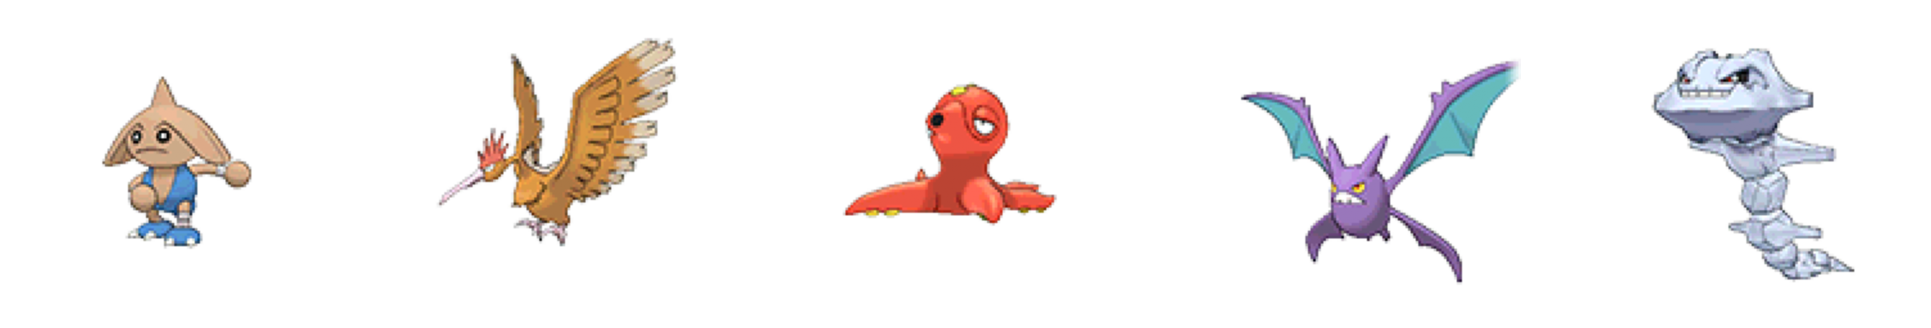

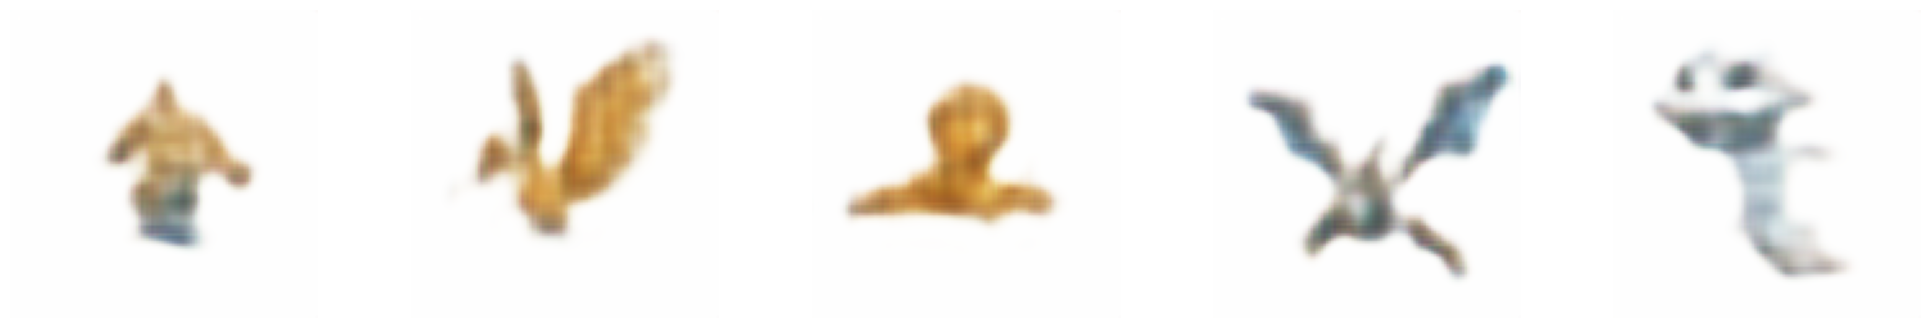

In [25]:
plot_images(x_test)
plot_images(x_test_pred)

Much better! but still not perfect.

**Exercise**

Play with the above model to improve performance.

# Denoising using U-net

Often, we do not have to do all the architectural engineering ourselves. 

A very oft-used CNN autoencoder-type architecture is the *U-net*, developed in [this paper](https://arxiv.org/abs/1505.04597).

It is very often the case that well-known architectures have been implemented by others in keras. This is the case for U-net. We will use the following [package](https://arxiv.org/abs/1505.04597). You can install it by issuing
```
$pip install keras-unet
```

In [26]:
from keras_unet.models import custom_unet

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


We will train a denoising autoencoder, by minimizing the difference between a noise-corrupted input and a clean input, i.e. we minimize
$$
    L(\mathbf{x}, \mathrm{Decoder}(\mathrm{Encoder(\mathbf{x + \mathrm{Noise}})}))
$$

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

We write a simple function to add noise to the input, scaled by the `std` parameter.

In [28]:
def add_gaussian_noise(x, std=0.1):
    x_noisy =  x + np.random.normal(scale=std, size=x.shape)
    return np.clip(x_noisy, 0.0, 1.0)

In [29]:
autoencoder = custom_unet(
    input_shape=(120, 120, 3),
    num_layers=3,
    num_classes=3,
)

We can do on-the-fly noise generation by the `ImageDataGenerator` class. We have previously used this for data augmentation.

In [30]:
data_gen = ImageDataGenerator(preprocessing_function=add_gaussian_noise)

In [31]:
generator = data_gen.flow(x=x_train, y=x_train, batch_size=64)

In [32]:
train_and_save(
    model=autoencoder,
    path=Path('./pokemon_ae_denoise_unet.h5'),
    x=generator,
    validation_data=(x_test, x_test),
    verbose=0,
    epochs=80,
    callbacks=[TqdmCallback(verbose=1)],
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Let us now test our model's performance on noise-corrupted test data.

In [33]:
x_test_noisy = add_gaussian_noise(x_test, std=0.1)
x_test_pred_noisy = autoencoder.predict(x_test_noisy)

3/3 [==============================] - 1s 255ms/step


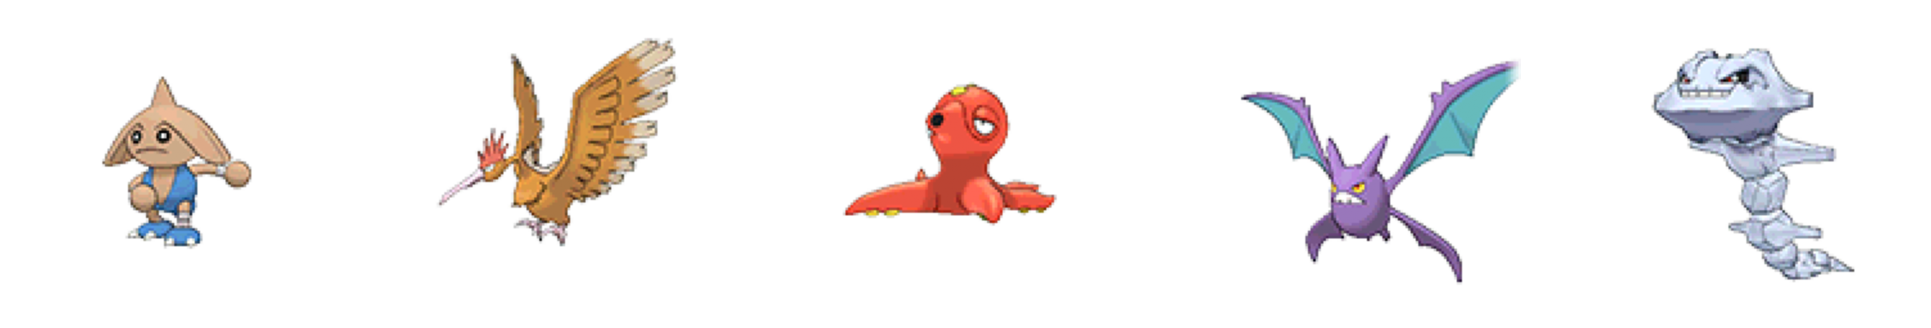

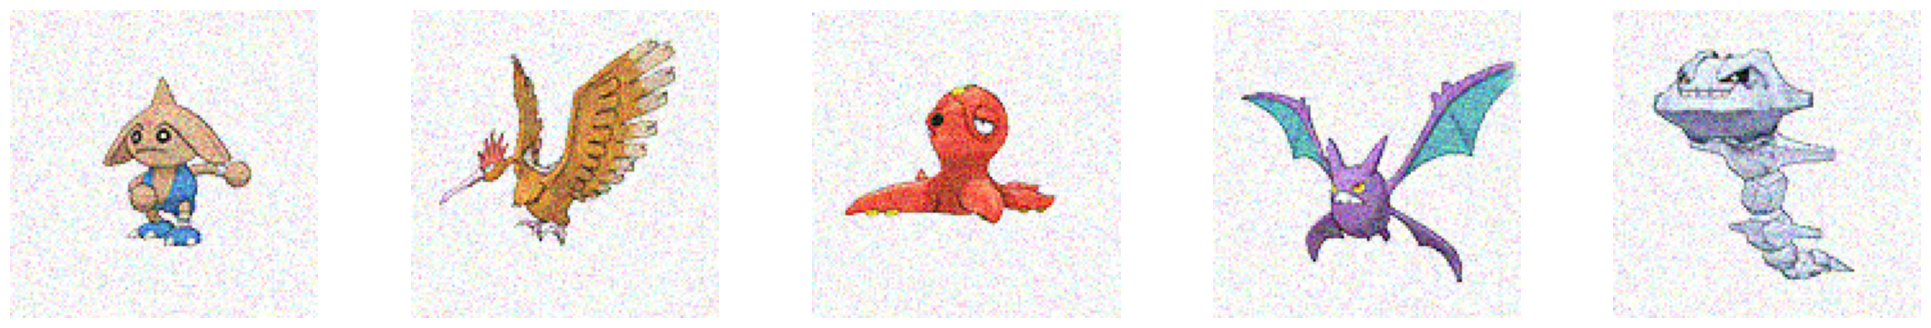

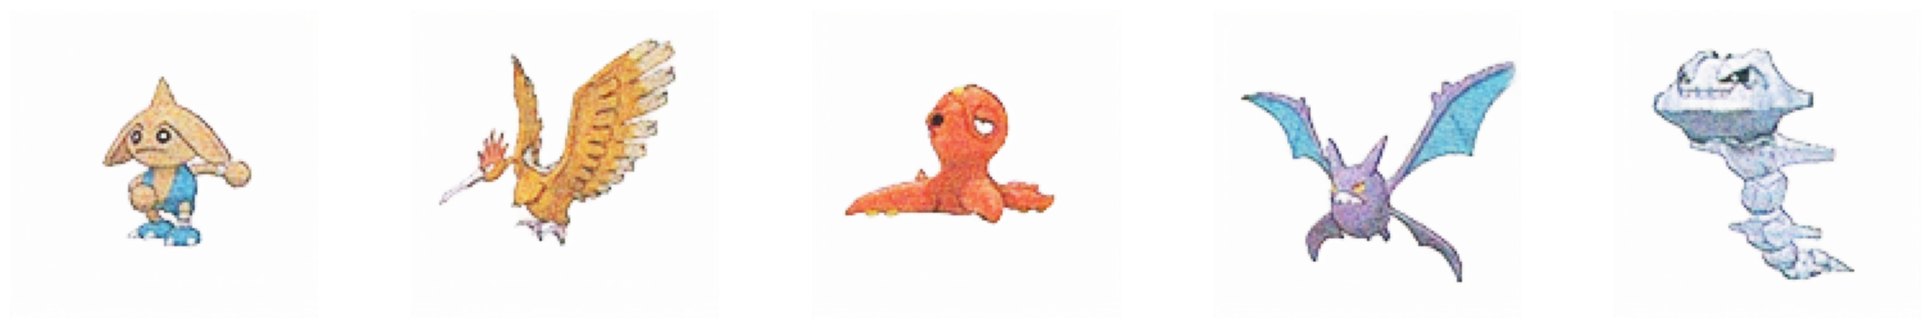

In [34]:
plot_images(x_test)
plot_images(x_test_noisy)
plot_images(x_test_pred_noisy)

# Exercise

Explore the performance of the model under different noise distributions, e.g.
  * correlated Gaussian
  * uniform

How do we make the model more robust to different types of perturbations?